# Generic Two‑Stage Temporal Process Classifier (Stage‑1 = first word)

This notebook trains a **two-stage** temporal classifier for industrial process recognition from video:

- **Stage‑1 (coarse)** label = **first word** of the clip filename label (e.g. `collect_hardware_bolts_rnva` → `collect`)
- **Stage‑2 (fine)** label = **full clip label** (e.g. `collect_hardware_bolts_rnva`)

At inference on a **long/unseen** video:
1. Stage‑1 predicts a **stable coarse timeline** (with smoothing + short‑segment merging).
2. For each coarse segment, Stage‑2 (specific to that coarse family) predicts a **single fine label** for the segment.

Why this helps:
- Single-stage “full-label” classification tends to be **jittery** on unseen videos (many spurious label flips).
- Two-stage reduces search space and makes predictions more stable.

---

## Key concepts
- **Resampling**: videos have different FPS; we sample frames to a common `TARGET_FPS` so time steps align.
- **Chunk / step**: we group sampled frames into blocks of `CLIP_LEN` frames.  
  Each chunk becomes **one 512‑D feature** from R3D‑18.
- **T**: number of chunks/steps for a clip/video.
- **Padding/cropping**: training batches need same `T` → we pad by repeating the last feature or crop.

> You can change `TARGET_FPS`, `CLIP_LEN`, `FIXED_T` to trade speed vs stability.

In [1]:

# ============================================================
# CELL 1) Imports + Config
# ============================================================
import os, re, json, math, glob, hashlib
from pathlib import Path
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision.models.video import r3d_18, R3D_18_Weights

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# ----------------------------
# Paths (EDIT THESE)
# ----------------------------
CLIPS_DIR  = r"C:\Users\a90010986\Downloads\Action Segmentation Model\Action Segmentation Model\data"
TEST_VIDEO = r"C:\Users\a90010986\Downloads\Action Segmentation Model\Action Segmentation Model\test_sample_short_video.mp4"

OUT_DIR   = "outputs_two_stage"
CACHE_DIR = os.path.join(OUT_DIR, "feat_cache")

STAGE1_DIR = os.path.join(OUT_DIR, "stage1")
STAGE2_DIR = os.path.join(OUT_DIR, "stage2")

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(STAGE1_DIR, exist_ok=True)
os.makedirs(STAGE2_DIR, exist_ok=True)

# ----------------------------
# Feature extraction params
# ----------------------------
TARGET_FPS = 8          # common fps for all videos (lower = faster + more stable, but less detail)
CLIP_LEN   = 16         # frames per chunk fed to R3D-18 (chunk duration = CLIP_LEN / TARGET_FPS seconds)

# ----------------------------
# Training params
# ----------------------------
FIXED_T    = 64         # number of chunks per training clip after pad/crop (batching needs fixed T)
BATCH_SIZE = 4
EPOCHS_1   = 40         # stage-1 epochs
EPOCHS_2   = 50         # stage-2 epochs per family
LR         = 1e-3
WEIGHT_DECAY = 1e-4

# ----------------------------
# Inference smoothing params
# ----------------------------
SMOOTH_K_STAGE1 = 9     # odd window for smoothing stage-1 step labels
MIN_SEG_DUR_S   = 1.0   # merge segments shorter than this (seconds)
SMOOTH_K_STAGE2 = 5     # optional smoothing inside stage-2 segment

# ----------------------------
# Device
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)
print("torch:", torch.__version__, "| CUDA build:", torch.version.cuda, "| CUDA available:", torch.cuda.is_available())

DEVICE: cuda
torch: 2.5.1+cu121 | CUDA build: 12.1 | CUDA available: True


In [2]:

# ============================================================
# CELL 2) Label parsing (GENERIC)
#   - fine label: full normalized filename stem
#   - stage-1 label: first word (split by underscore)
# ============================================================
def normalize_label_from_filename(path: str) -> str:
    stem = Path(path).stem.lower()
    stem = re.sub(r"[\(\)\[\]\{\}]", " ", stem)
    stem = re.sub(r"[^a-z0-9]+", "_", stem)
    stem = re.sub(r"_+", "_", stem).strip("_")
    return stem if stem else "unknown"

def stage1_from_fine_label(fine_label: str) -> str:
    # first word = token before first underscore
    if not fine_label:
        return "unknown"
    parts = fine_label.split("_")
    return parts[0] if len(parts) else "unknown"

In [3]:

# ============================================================
# CELL 3) Scan clips -> dataframe
# ============================================================
def list_videos(root: str) -> List[str]:
    exts = ["*.mp4", "*.avi", "*.mov", "*.mkv", "*.MP4", "*.AVI", "*.MOV", "*.MKV"]
    out = []
    for e in exts:
        out.extend(glob.glob(os.path.join(root, e)))
    return sorted(out)

videos = list_videos(CLIPS_DIR)
print("Found clips:", len(videos))
assert len(videos) > 0, "No clips found. Check CLIPS_DIR path."

df = pd.DataFrame({"video": videos})
df["fine_label"]  = df["video"].apply(normalize_label_from_filename)
df["stage1_label"] = df["fine_label"].apply(stage1_from_fine_label)

print("Unique fine labels:", df["fine_label"].nunique())
print("Unique stage1 labels:", df["stage1_label"].nunique())
display(df.head())

Found clips: 310
Unique fine labels: 152
Unique stage1 labels: 26


,video,fine_label,stage1_label
0,C:\Users\a90010986\Downloads\Action Segmentati...,apply_loctite_and_prepare_valve_rnva,apply
1,C:\Users\a90010986\Downloads\Action Segmentati...,apply_loctite_and_prepare_valve_rnva,apply
2,C:\Users\a90010986\Downloads\Action Segmentati...,apply_grease_on_block_and_piston_rnva,apply
3,C:\Users\a90010986\Downloads\Action Segmentati...,apply_grease_on_block_and_piston_rnva,apply
4,C:\Users\a90010986\Downloads\Action Segmentati...,apply_grease_on_housing_rnva,apply


In [5]:

# ============================================================
# CELL 4) Dataset diagnostics (optional but useful)
# ============================================================
print("Total clips:", len(df))
print("\nTop stage1 counts:")
display(df["stage1_label"].value_counts().head(20))

print("\nTop fine-label counts:")
display(df["fine_label"].value_counts().head(20))

# quick sanity about singleton problem
n_singletons = int((df["fine_label"].value_counts() == 1).sum())
print(f"\nSingleton fine labels (count==1): {n_singletons} / {df['fine_label'].nunique()}")

Total clips: 310

Top stage1 counts:


stage1_label
mount         72
get           38
attach        22
collect       18
apply         16
position      16
tight         16
remove        12
hand          12
lift          12
unwrap        10
mark          10
inspect       10
wait           6
feed           6
scan           6
clean          4
discussion     4
fill           4
fix            4
Name: count, dtype: int64


Top fine-label counts:


fine_label
inspect_check_check_checklist_rnva                           4
tight_bolts_using_gun_va                                     4
get_o_ring_rnva                                              4
apply_loctite_and_prepare_valve_rnva                         2
apply_loctite_on_part_rnva                                   2
apply_grease_on_block_and_piston_rnva                        2
apply_grease_on_housing_rnva                                 2
apply_loctite_rnva                                           2
attach_detach_attach_crane_chain_to_element_assembly_rnva    2
attach_detach_attach_crane_chain_rnva                        2
attach_detach_attach_eyebolt_on_vessel_rnva                  2
attach_detach_attach_lifting_tool_to_crane_rnva              2
attach_detach_detach_lifting_tool_to_crane_rnva              2
attach_detach_detach_crane_chain_rnva                        2
attach_detach_detach_eyebolts_from_crane_chain_rnva          2
attach_detach_detach_chain_from_crane_rnva  


Singleton fine labels (count==1): 0 / 152


In [6]:

# ============================================================
# CELL 5) R3D-18 feature extractor (512-D per chunk)
# ============================================================
def build_r3d18_feature_extractor(device: str = "cpu"):
    weights = R3D_18_Weights.KINETICS400_V1
    base = r3d_18(weights=weights)
    base.fc = nn.Identity()  # output [B,512]
    base.eval().to(device)

    # Kinetics-400 mean/std for torchvision video models
    mean = torch.tensor([0.43216, 0.394666, 0.37645], dtype=torch.float32).view(1,3,1,1,1).to(device)
    std  = torch.tensor([0.22803, 0.22145, 0.216989], dtype=torch.float32).view(1,3,1,1,1).to(device)
    return base, mean, std

backbone_r3d, r3d_mean, r3d_std = build_r3d18_feature_extractor(DEVICE)
FEATURE_DIM = 512
print("✅ backbone ready | FEATURE_DIM =", FEATURE_DIM)

✅ backbone ready | FEATURE_DIM = 512


In [8]:

# ============================================================
# CELL 6) Video helpers + feature extraction + caching (hashed)
# ============================================================
def read_video_meta(video_path: str):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps is None or fps <= 1e-6:
        fps = 25.0
    nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    return float(fps), int(nframes), int(w), int(h)

def sample_frame_indices(src_fps: float, nframes: int, target_fps: int) -> np.ndarray:
    if nframes <= 0:
        return np.array([], dtype=np.int64)
    step = max(1, int(round(src_fps / float(target_fps))))
    return np.arange(0, nframes, step, dtype=np.int64)

def load_frames_rgb(video_path: str, frame_indices: np.ndarray, resize_hw=(112,112)) -> torch.Tensor:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")

    frames = []
    idx_set = set(frame_indices.tolist())
    cur = 0
    want_ptr = 0
    want_len = len(frame_indices)

    while True:
        ok, frame_bgr = cap.read()
        if not ok:
            break
        if cur in idx_set:
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            if resize_hw is not None:
                frame_rgb = cv2.resize(frame_rgb, resize_hw, interpolation=cv2.INTER_AREA)
            frames.append(frame_rgb)
            want_ptr += 1
            if want_ptr >= want_len:
                break
        cur += 1

    cap.release()
    if len(frames) == 0:
        return torch.empty((0, resize_hw[1], resize_hw[0], 3), dtype=torch.uint8)
    arr = np.stack(frames, axis=0)  # [N,H,W,3]
    return torch.from_numpy(arr).to(torch.uint8)

@torch.no_grad()
def extract_features_steps_r3d18(video_path: str, target_fps: int, clip_len: int) -> Tuple[torch.Tensor, torch.Tensor, float]:
    '''
    Video -> sample frames at ~target_fps -> chunk into steps of clip_len frames
    -> R3D-18 -> 512-D feature per step.
    Returns:
      feats: [T,512]
      ts:    [T] start time (seconds) of each step
      src_fps: original fps
    '''
    src_fps, nframes, _, _ = read_video_meta(video_path)
    idx = sample_frame_indices(src_fps, nframes, target_fps)
    if len(idx) == 0:
        return torch.zeros((1,FEATURE_DIM), dtype=torch.float32), torch.zeros((1,), dtype=torch.float32), float(src_fps)

    frames = load_frames_rgb(video_path, idx, resize_hw=(112,112))
    if frames.shape[0] == 0:
        return torch.zeros((1,FEATURE_DIM), dtype=torch.float32), torch.zeros((1,), dtype=torch.float32), float(src_fps)

    x = frames.float() / 255.0
    x = x.permute(0,3,1,2)  # [N,3,112,112]
    N = x.shape[0]
    n_steps = int(math.ceil(N / clip_len))

    sampled_times = (idx.astype(np.float32) / float(src_fps))  # time per sampled frame index

    feats, ts = [], []
    for s in range(n_steps):
        a = s * clip_len
        b = min((s+1) * clip_len, N)
        chunk = x[a:b]
        if chunk.shape[0] < clip_len:
            pad = chunk[-1:].repeat(clip_len - chunk.shape[0], 1, 1, 1)
            chunk = torch.cat([chunk, pad], dim=0)

        chunk = chunk.permute(1,0,2,3).unsqueeze(0).to(DEVICE)  # [1,3,T,H,W]
        chunk = (chunk - r3d_mean) / r3d_std

        f = backbone_r3d(chunk)  # [1,512]
        feats.append(f.squeeze(0).detach().cpu())

        t0 = float(sampled_times[a]) if a < len(sampled_times) else float(sampled_times[-1])
        ts.append(t0)

    feats = torch.stack(feats, dim=0).float()
    ts = torch.tensor(ts, dtype=torch.float32)
    return feats, ts, float(src_fps)

def cache_key(video_path: str, target_fps: int, clip_len: int) -> str:
    s = f"{Path(video_path).as_posix()}|fps={target_fps}|len={clip_len}"
    h = hashlib.md5(s.encode("utf-8")).hexdigest()
    return f"vid_{h}__fps{target_fps}__len{clip_len}"

def get_cached_features(video_path: str, target_fps: int, clip_len: int):
    key = cache_key(video_path, target_fps, clip_len)
    feat_path = os.path.join(CACHE_DIR, key + ".pt")
    meta_path = os.path.join(CACHE_DIR, key + ".json")

    if os.path.exists(feat_path) and os.path.exists(meta_path):
        try:
            data = torch.load(feat_path, map_location="cpu")
            with open(meta_path, "r", encoding="utf-8") as f:
                meta = json.load(f)
            feats = data["feats"]
            ts = data["ts"]
            src_fps = float(meta.get("src_fps", 0.0))
            if feats.ndim != 2 or ts.ndim != 1 or feats.shape[0] != ts.shape[0]:
                raise ValueError("Cache sanity failed")
            return feats, ts, src_fps
        except Exception as e:
            print(f"⚠️ Cache load failed, recomputing: {Path(video_path).name} | {repr(e)}")

    feats, ts, src_fps = extract_features_steps_r3d18(video_path, target_fps, clip_len)
    torch.save({"feats": feats, "ts": ts}, feat_path)
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump({"src_fps": float(src_fps)}, f, indent=2)
    return feats, ts, float(src_fps)

In [9]:

# ============================================================
# CELL 7) Pad/Crop + Dataset + Collate
# ============================================================
def pad_or_crop_2d(x: torch.Tensor, T: int) -> torch.Tensor:
    t, d = x.shape
    if t == T:
        return x
    if t > T:
        return x[:T]
    # pad by repeating last row
    pad = x[-1:].repeat(T - t, 1)
    return torch.cat([x, pad], dim=0)

def pad_or_crop_1d(x: torch.Tensor, T: int) -> torch.Tensor:
    t = x.shape[0]
    if t == T:
        return x
    if t > T:
        return x[:T]
    pad = x[-1:].repeat(T - t)
    return torch.cat([x, pad], dim=0)

def collate_fixedT(batch):
    xs = torch.stack([b["x"] for b in batch], dim=0)       # [B,T,D]
    ys = torch.tensor([b["y"] for b in batch], dtype=torch.long)
    ts = torch.stack([b["ts"] for b in batch], dim=0)      # [B,T]
    return {"x": xs, "y": ys, "ts": ts, "video": [b["video"] for b in batch]}

class ClipDataset(Dataset):
    def __init__(self, df: pd.DataFrame, label_col: str, label_to_id: Dict[str,int],
                 target_fps: int, clip_len: int, fixed_T: int):
        self.df = df.reset_index(drop=True)
        self.label_col = label_col
        self.label_to_id = label_to_id
        self.target_fps = int(target_fps)
        self.clip_len = int(clip_len)
        self.fixed_T = int(fixed_T)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        video_path = str(row["video"])
        label_name = str(row[self.label_col])
        if label_name not in self.label_to_id:
            raise KeyError(f"Label '{label_name}' not found in label map for '{self.label_col}'")
        y = int(self.label_to_id[label_name])

        feats, ts, src_fps = get_cached_features(video_path, self.target_fps, self.clip_len)
        feats = pad_or_crop_2d(feats, self.fixed_T)
        ts    = pad_or_crop_1d(ts, self.fixed_T)

        return {"x": feats.float(), "y": y, "video": video_path, "ts": ts.float(), "src_fps": float(src_fps)}

In [10]:

# ============================================================
# CELL 8) Temporal classifier (simple MLP per timestep)
#   Input:  [B,T,512] -> Output: [B,T,C]
# ============================================================
class TemporalClassifier(nn.Module):
    def __init__(self, in_dim: int, num_classes: int, hidden: int = 256):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden, num_classes),
        )

    def forward(self, x):
        B, T, D = x.shape
        y = self.net(x.reshape(B*T, D))
        return y.reshape(B, T, -1)

In [11]:

# ============================================================
# CELL 9) Training helpers
# ============================================================
def majority_vote(pred_steps: np.ndarray) -> int:
    vals, counts = np.unique(pred_steps, return_counts=True)
    return int(vals[np.argmax(counts)])

def run_epoch(model, loader, optimizer=None):
    train = optimizer is not None
    model.train(train)

    total_loss, total_correct, total = 0.0, 0, 0
    if len(loader) == 0:
        return float("nan"), 0.0

    for batch in tqdm(loader, leave=False):
        x = batch["x"].to(DEVICE)  # [B,T,512]
        y = batch["y"].to(DEVICE)  # [B]
        B, T, _ = x.shape

        logits = model(x)          # [B,T,C]
        y_steps = y.view(B, 1).repeat(1, T)
        loss = F.cross_entropy(logits.reshape(-1, logits.shape[-1]), y_steps.reshape(-1))

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += float(loss.item()) * B

        with torch.no_grad():
            pred_steps = logits.argmax(dim=-1).detach().cpu().numpy()
            for i in range(B):
                pred_clip = majority_vote(pred_steps[i])
                total_correct += int(pred_clip == int(y[i].item()))
                total += 1

    return total_loss / max(total, 1), total_correct / max(total, 1)

def train_model(model, train_loader, epochs: int,
                best_path: str, last_path: str,
                val_loader=None, save_best_on: str = "loss"):
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_metric = float("inf")

    print("✅ Starting training")
    print("Train batches:", len(train_loader), "| Val batches:", 0 if (val_loader is None or len(val_loader)==0) else len(val_loader))

    for ep in range(1, epochs + 1):
        tr_loss, tr_acc = run_epoch(model, train_loader, optimizer=opt)
        hist["train_loss"].append(tr_loss)
        hist["train_acc"].append(tr_acc)

        if val_loader is not None and len(val_loader) > 0:
            with torch.no_grad():
                va_loss, va_acc = run_epoch(model, val_loader, optimizer=None)
            hist["val_loss"].append(va_loss)
            hist["val_acc"].append(va_acc)
            metric = va_loss if save_best_on == "loss" else (1.0 - va_acc)
            print(f"Epoch {ep:03d}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")
        else:
            metric = tr_loss
            print(f"Epoch {ep:03d}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.3f}")

        if metric < best_metric:
            best_metric = metric
            torch.save(model.state_dict(), best_path)
            print("✅ saved best ->", best_path)

        torch.save(model.state_dict(), last_path)

    print("✅ Finished. Best metric =", best_metric)
    print("✅ Last checkpoint ->", last_path)
    return hist

def plot_history(hist, title=""):
    plt.figure()
    plt.plot(hist["train_loss"], label="train_loss")
    if len(hist["val_loss"]) > 0:
        plt.plot(hist["val_loss"], label="val_loss")
    plt.title(f"{title} loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.show()

    plt.figure()
    plt.plot(hist["train_acc"], label="train_acc")
    if len(hist["val_acc"]) > 0:
        plt.plot(hist["val_acc"], label="val_acc")
    plt.title(f"{title} accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend(); plt.show()

Stage-1 classes: 26
Stage-1 train clips: 310
Stage-1 batch x: torch.Size([4, 64, 512])
✅ Starting training
Train batches: 78 | Val batches: 0


C:\Users\a90010986\AppData\Local\Temp\ipykernel_36276\36203772.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(feat_path, map_location="cpu")


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 001/40 | train loss 2.7155 acc 0.261
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 002/40 | train loss 1.7761 acc 0.500
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 003/40 | train loss 0.9740 acc 0.823
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 004/40 | train loss 0.5448 acc 0.948
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 005/40 | train loss 0.3894 acc 0.974
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 006/40 | train loss 0.3170 acc 0.984
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 007/40 | train loss 0.2968 acc 0.994
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 008/40 | train loss 0.2028 acc 0.997
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 009/40 | train loss 0.1619 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 010/40 | train loss 0.1245 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 011/40 | train loss 0.1038 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 012/40 | train loss 0.0867 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 013/40 | train loss 0.0650 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 014/40 | train loss 0.0565 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 015/40 | train loss 0.0455 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 016/40 | train loss 0.0385 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 017/40 | train loss 0.0285 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 018/40 | train loss 0.0258 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 019/40 | train loss 0.0207 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 020/40 | train loss 0.0157 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 021/40 | train loss 0.0167 acc 1.000


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 022/40 | train loss 0.0111 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 023/40 | train loss 0.0111 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 024/40 | train loss 0.0111 acc 1.000


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 025/40 | train loss 0.0094 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 026/40 | train loss 0.0088 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 027/40 | train loss 0.0071 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 028/40 | train loss 0.0063 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 029/40 | train loss 0.0049 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 030/40 | train loss 0.0054 acc 1.000


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 031/40 | train loss 0.0047 acc 1.000
✅ saved best -> outputs_two_stage\stage1\best.pt


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 032/40 | train loss 0.0054 acc 1.000


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 033/40 | train loss 0.1910 acc 0.977


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 034/40 | train loss 0.4010 acc 0.942


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 035/40 | train loss 0.1991 acc 0.984


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 036/40 | train loss 0.0460 acc 1.000


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 037/40 | train loss 0.0269 acc 1.000


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 038/40 | train loss 0.0172 acc 1.000


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 039/40 | train loss 0.0134 acc 1.000


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 040/40 | train loss 0.0128 acc 1.000
✅ Finished. Best metric = 0.004700705514856494
✅ Last checkpoint -> outputs_two_stage\stage1\last.pt


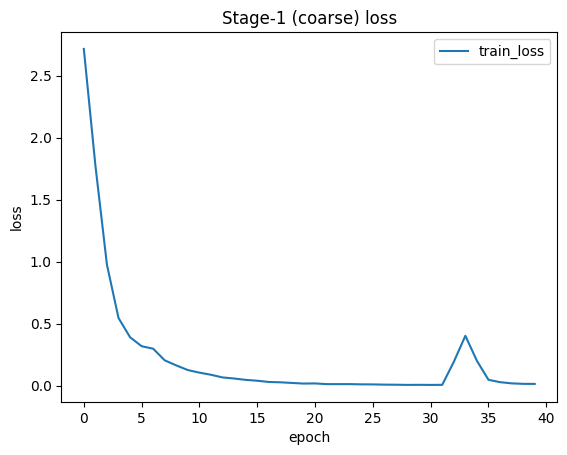

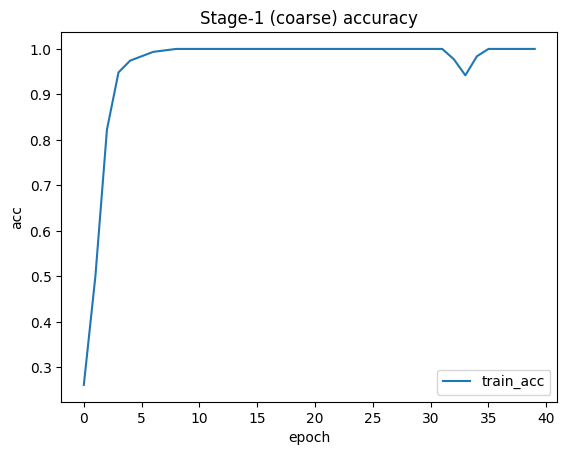

Saved Stage-1: outputs_two_stage\stage1\best.pt | outputs_two_stage\stage1\last.pt


In [12]:

# ============================================================
# CELL 10) Train Stage-1 model (coarse labels)
# ============================================================
stage1_labels = sorted(df["stage1_label"].unique().tolist())
stage1_l2i = {name: i for i, name in enumerate(stage1_labels)}
stage1_i2l = {i: n for n, i in stage1_l2i.items()}

with open(os.path.join(STAGE1_DIR, "label_to_id.json"), "w", encoding="utf-8") as f:
    json.dump(stage1_l2i, f, indent=2)

train_df_stage1 = df.copy()

train_ds1 = ClipDataset(train_df_stage1, label_col="stage1_label", label_to_id=stage1_l2i,
                        target_fps=TARGET_FPS, clip_len=CLIP_LEN, fixed_T=FIXED_T)
train_loader1 = DataLoader(train_ds1, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fixedT)

print("Stage-1 classes:", len(stage1_l2i))
print("Stage-1 train clips:", len(train_ds1))
b = next(iter(train_loader1))
print("Stage-1 batch x:", b["x"].shape)

stage1_model = TemporalClassifier(in_dim=FEATURE_DIM, num_classes=len(stage1_l2i)).to(DEVICE)

BEST1 = os.path.join(STAGE1_DIR, "best.pt")
LAST1 = os.path.join(STAGE1_DIR, "last.pt")

hist1 = train_model(stage1_model, train_loader1, epochs=EPOCHS_1, best_path=BEST1, last_path=LAST1, val_loader=None)
plot_history(hist1, title="Stage-1 (coarse)")
print("Saved Stage-1:", BEST1, "|", LAST1)

In [13]:

# ============================================================
# CELL 11) Train Stage-2 models (one per stage-1 family)
#   fine label classification inside each family.
# ============================================================
def train_stage2_for_family(family: str, df_family: pd.DataFrame) -> Dict:
    out_dir = os.path.join(STAGE2_DIR, family)
    os.makedirs(out_dir, exist_ok=True)

    fine_labels = sorted(df_family["fine_label"].unique().tolist())
    l2i = {name: i for i, name in enumerate(fine_labels)}
    with open(os.path.join(out_dir, "label_to_id.json"), "w", encoding="utf-8") as f:
        json.dump(l2i, f, indent=2)

    ds = ClipDataset(df_family, label_col="fine_label", label_to_id=l2i,
                     target_fps=TARGET_FPS, clip_len=CLIP_LEN, fixed_T=FIXED_T)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fixedT)

    model = TemporalClassifier(in_dim=FEATURE_DIM, num_classes=len(l2i)).to(DEVICE)
    best = os.path.join(out_dir, "best.pt")
    last = os.path.join(out_dir, "last.pt")

    hist = train_model(model, loader, epochs=EPOCHS_2, best_path=best, last_path=last, val_loader=None)
    return {
        "family": family,
        "n_clips": int(len(df_family)),
        "n_classes": int(len(l2i)),
        "best_ckpt": best,
        "last_ckpt": last,
    }

stage2_registry = {}
families = sorted(df["stage1_label"].unique().tolist())

for fam in families:
    df_fam = df[df["stage1_label"] == fam].copy()
    nclips = len(df_fam)
    nclasses = df_fam["fine_label"].nunique()

    print("\n" + "="*70)
    print(f"Stage-2 family '{fam}': clips={nclips} fine_classes={nclasses}")

    # Heuristic: if there is only 1 fine class, stage-2 adds no value
    if nclasses <= 1:
        print("⏭️ Skipping stage-2 (only 1 fine label in this family).")
        stage2_registry[fam] = {"trained": False, "reason": "single_class", "n_clips": int(nclips), "n_classes": int(nclasses)}
        continue

    # If too few clips, training will overfit; still allow training if you want.
    if nclips < 2:
        print("⏭️ Skipping stage-2 (too few clips).")
        stage2_registry[fam] = {"trained": False, "reason": "too_few_clips", "n_clips": int(nclips), "n_classes": int(nclasses)}
        continue

    info = train_stage2_for_family(fam, df_fam)
    info["trained"] = True
    stage2_registry[fam] = info

with open(os.path.join(STAGE2_DIR, "stage2_registry.json"), "w", encoding="utf-8") as f:
    json.dump(stage2_registry, f, indent=2)

print("\n✅ Stage-2 training complete.")
print("Registry saved:", os.path.join(STAGE2_DIR, "stage2_registry.json"))


Stage-2 family 'apply': clips=16 fine_classes=8
✅ Starting training
Train batches: 4 | Val batches: 0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 001/50 | train loss 2.1039 acc 0.125
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


C:\Users\a90010986\AppData\Local\Temp\ipykernel_36276\36203772.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(feat_path, map_location="cpu")


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 002/50 | train loss 1.5629 acc 0.938
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.9732 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.4426 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.2045 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.1292 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.1038 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.0781 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0595 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0388 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0274 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0168 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0118 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0081 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0073 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0058 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0043 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0035 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0026 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0024 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0021 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0019 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0024 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0024 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0019 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0017 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0022 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0012 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0013 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0018 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0013 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0010 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0008 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0008 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0018 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0006 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0007 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0008 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0008 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0008 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0006 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0006 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0009 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0004 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0004 acc 1.000
✅ saved best -> outputs_two_stage\stage2\apply\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0004 acc 1.000
✅ Finished. Best metric = 0.0003546005973475985
✅ Last checkpoint -> outputs_two_stage\stage2\apply\last.pt

Stage-2 family 'attach': clips=22 fine_classes=11
✅ Starting training
Train batches: 6 | Val batches: 0


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 001/50 | train loss 2.4434 acc 0.182
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 002/50 | train loss 1.8293 acc 0.818
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 003/50 | train loss 1.1419 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.5664 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.3189 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.2440 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.2059 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.1800 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.1589 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.1310 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.1266 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.1011 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0965 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0893 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0701 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0652 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0588 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0641 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0533 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0480 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0433 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0449 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0533 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0355 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0392 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0277 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0310 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0234 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0235 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0224 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0134 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0150 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0138 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0148 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0103 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0107 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0103 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0099 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0090 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0081 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0101 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0062 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0049 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0065 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0058 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0061 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0063 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0059 acc 1.000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0044 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0041 acc 1.000
✅ saved best -> outputs_two_stage\stage2\attach\best.pt
✅ Finished. Best metric = 0.004090498053384098
✅ Last checkpoint -> outputs_two_stage\stage2\attach\last.pt

Stage-2 family 'clean': clips=4 fine_classes=2
✅ Starting training
Train batches: 1 | Val batches: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 001/50 | train loss 0.7160 acc 0.250
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 002/50 | train loss 0.4696 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.3135 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.2079 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.1463 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.1143 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.0885 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.0665 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0474 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0398 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0361 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0228 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0245 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0131 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0137 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0099 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0048 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0015 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0013 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0007 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0009 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0003 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0003 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0003 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0004 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0001 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0002 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0001 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0001 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0001 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0001 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0001 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0001 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0001 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0001 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0001 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0001 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0001 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0001 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\clean\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0000 acc 1.000
✅ Finished. Best metric = 1.8319655282539316e-05
✅ Last checkpoint -> outputs_two_stage\stage2\clean\last.pt

Stage-2 family 'collect': clips=18 fine_classes=9
✅ Starting training
Train batches: 5 | Val batches: 0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001/50 | train loss 2.1016 acc 0.389
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002/50 | train loss 1.4840 acc 0.778
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.8682 acc 0.889
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.4453 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.2647 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.1663 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.1119 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.0972 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0731 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0642 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0309 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0409 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0224 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0167 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0198 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0137 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0100 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0080 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0085 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0050 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0034 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0044 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0034 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0029 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0028 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0025 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0032 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0024 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0018 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0018 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0015 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0013 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0019 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0017 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0013 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0013 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0012 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0012 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0018 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0011 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0011 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0012 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0007 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0008 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0006 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0007 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0010 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0007 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0007 acc 1.000


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\collect\best.pt
✅ Finished. Best metric = 0.0005147780854410181
✅ Last checkpoint -> outputs_two_stage\stage2\collect\last.pt

Stage-2 family 'cut': clips=2 fine_classes=1
⏭️ Skipping stage-2 (only 1 fine label in this family).

Stage-2 family 'discussion': clips=4 fine_classes=2
✅ Starting training
Train batches: 1 | Val batches: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 001/50 | train loss 0.7308 acc 0.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 002/50 | train loss 0.4908 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.3338 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.2185 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.1333 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.0818 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.0435 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.0268 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0169 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0085 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0056 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0019 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0013 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0007 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0004 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0002 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0001 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0001 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0001 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0001 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\discussion\best.pt
✅ Finished. Best metric = 2.784638581943e-07
✅ Last checkpoint -> outputs_two_stage\stage2\discussion\last.pt

Stage-2 family 'excess': clips=2 fine_classes=1
⏭️ Skipping stage-2 (only 1 fine label in this family).

Stage-2 family 'feed': clips=6 fine_classes=3
✅ Starting training
Train batches: 2 | Val batches: 0


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 001/50 | train loss 1.1773 acc 0.333
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 002/50 | train loss 0.7655 acc 0.833
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.5248 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.3461 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.2131 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.1398 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.1005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.0906 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0857 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0618 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0453 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0333 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0247 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0164 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0127 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0095 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0079 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0115 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0047 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0030 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0030 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0020 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0018 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0014 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0012 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0010 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0007 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0010 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0007 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0006 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0007 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0006 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0004 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0003 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0006 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0004 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0004 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0003 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0004 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0005 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0003 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0004 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0003 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0003 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0003 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0002 acc 1.000
✅ saved best -> outputs_two_stage\stage2\feed\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0002 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0003 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0003 acc 1.000
✅ Finished. Best metric = 0.00019135417096549645
✅ Last checkpoint -> outputs_two_stage\stage2\feed\last.pt

Stage-2 family 'fill': clips=4 fine_classes=2
✅ Starting training
Train batches: 1 | Val batches: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 001/50 | train loss 0.6971 acc 0.750
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 002/50 | train loss 0.4355 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.2730 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.1518 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.0689 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.0296 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.0103 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.0033 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0012 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0002 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0001 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0001 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fill\best.pt
✅ Finished. Best metric = 1.3038510715546181e-08
✅ Last checkpoint -> outputs_two_stage\stage2\fill\last.pt

Stage-2 family 'fix': clips=4 fine_classes=2
✅ Starting training
Train batches: 1 | Val batches: 0


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 001/50 | train loss 0.7133 acc 0.500
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 002/50 | train loss 0.4209 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.2365 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.1058 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.0411 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.0134 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.0044 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.0015 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0002 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0001 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\fix\best.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0000 acc 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0000 acc 1.000
✅ Finished. Best metric = 0.0
✅ Last checkpoint -> outputs_two_stage\stage2\fix\last.pt

Stage-2 family 'get': clips=38 fine_classes=18
✅ Starting training
Train batches: 10 | Val batches: 0


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001/50 | train loss 2.7742 acc 0.316
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 002/50 | train loss 1.9086 acc 0.737
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.9230 acc 0.947
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.4658 acc 0.974
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.3085 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.2522 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.1993 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.1659 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.1537 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.1181 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.1189 acc 1.000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0858 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0747 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0629 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0676 acc 1.000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0516 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0403 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0368 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0355 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0336 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0303 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0263 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0245 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0227 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0203 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0182 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0244 acc 1.000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0233 acc 1.000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0175 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0167 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0121 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0141 acc 1.000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0090 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0160 acc 1.000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0094 acc 1.000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0089 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0079 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0074 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0075 acc 1.000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0064 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0065 acc 1.000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0075 acc 1.000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0091 acc 1.000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0054 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0052 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0035 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0040 acc 1.000


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0032 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0029 acc 1.000
✅ saved best -> outputs_two_stage\stage2\get\best.pt


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0030 acc 1.000
✅ Finished. Best metric = 0.0029288738916971183
✅ Last checkpoint -> outputs_two_stage\stage2\get\last.pt

Stage-2 family 'hand': clips=12 fine_classes=6
✅ Starting training
Train batches: 3 | Val batches: 0


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 001/50 | train loss 1.8079 acc 0.250
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 002/50 | train loss 1.3358 acc 0.833
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.9293 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.6449 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.4517 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.3129 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.2624 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.1843 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.1534 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.1232 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0941 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0753 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0609 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0559 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0453 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0442 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0336 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0279 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0285 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0199 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0198 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0167 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0134 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0114 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0102 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0084 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0081 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0087 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0062 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0068 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0064 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0056 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0043 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0044 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0031 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0022 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0038 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0026 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0026 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0019 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0031 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0025 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0016 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0015 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0016 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0010 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0011 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0018 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0012 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0007 acc 1.000
✅ saved best -> outputs_two_stage\stage2\hand\best.pt
✅ Finished. Best metric = 0.0007284257735591382
✅ Last checkpoint -> outputs_two_stage\stage2\hand\last.pt

Stage-2 family 'inspect': clips=10 fine_classes=4
✅ Starting training
Train batches: 3 | Val batches: 0


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 001/50 | train loss 1.3570 acc 0.200
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 002/50 | train loss 0.8604 acc 0.800
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.5365 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.3129 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.1814 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.1288 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.1037 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.0815 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0777 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0568 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0555 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0506 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0268 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0236 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0241 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0207 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0100 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0097 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0050 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0082 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0053 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0033 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0027 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0024 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0019 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0018 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0021 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0013 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0013 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0011 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0010 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0010 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0009 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0008 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0008 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0006 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0008 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0008 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0006 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0006 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0008 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0007 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0008 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0004 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0003 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0005 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0003 acc 1.000
✅ saved best -> outputs_two_stage\stage2\inspect\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0003 acc 1.000
✅ Finished. Best metric = 0.00029212019871920346
✅ Last checkpoint -> outputs_two_stage\stage2\inspect\last.pt

Stage-2 family 'lift': clips=12 fine_classes=6
✅ Starting training
Train batches: 3 | Val batches: 0


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 001/50 | train loss 1.7660 acc 0.333
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 002/50 | train loss 1.3399 acc 0.917
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.9763 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.6335 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.3939 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.3075 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.2194 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.1866 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.1478 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.1505 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.1320 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.1018 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0913 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0688 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0686 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0535 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0389 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0423 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0416 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0325 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0253 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0239 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0224 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0129 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0181 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0103 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0145 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0096 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0060 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0069 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0047 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0052 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0033 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0049 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0040 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0031 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0026 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0030 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0022 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0018 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0019 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0018 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0023 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0023 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0017 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0013 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0012 acc 1.000
✅ saved best -> outputs_two_stage\stage2\lift\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0014 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0013 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0013 acc 1.000
✅ Finished. Best metric = 0.001223033284380411
✅ Last checkpoint -> outputs_two_stage\stage2\lift\last.pt

Stage-2 family 'mark': clips=10 fine_classes=5
✅ Starting training
Train batches: 3 | Val batches: 0


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 001/50 | train loss 1.4540 acc 0.600
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 002/50 | train loss 0.7752 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.3469 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.1565 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.0864 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.0639 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.0480 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.0434 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0305 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0251 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0139 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0118 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0071 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0065 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0040 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0027 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0026 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0015 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0017 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0009 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0010 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0007 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0013 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0010 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0009 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0008 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0006 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0006 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0005 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0005 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0010 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0004 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0005 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0004 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0003 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0004 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0006 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0002 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0003 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0003 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0002 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0002 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0002 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0002 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0002 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0001 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mark\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0002 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0001 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0003 acc 1.000
✅ Finished. Best metric = 0.00010443712235428393
✅ Last checkpoint -> outputs_two_stage\stage2\mark\last.pt

Stage-2 family 'mount': clips=72 fine_classes=36
✅ Starting training
Train batches: 18 | Val batches: 0


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 001/50 | train loss 3.6111 acc 0.097
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 002/50 | train loss 2.7731 acc 0.694
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 003/50 | train loss 1.5015 acc 0.875
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.7606 acc 0.972
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.5011 acc 0.972
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.3827 acc 0.986
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.3038 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.2527 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.2362 acc 0.986
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.2082 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.1671 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.1409 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.1229 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0963 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.1044 acc 1.000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0712 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0621 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0490 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0386 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0378 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0371 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0334 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0289 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0248 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0230 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0210 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0211 acc 1.000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0213 acc 1.000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0184 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0128 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0094 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0090 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0079 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0072 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0068 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0058 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0064 acc 1.000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0057 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0054 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0049 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0041 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0047 acc 1.000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0038 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0044 acc 1.000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0037 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0034 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0031 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0027 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0027 acc 1.000
✅ saved best -> outputs_two_stage\stage2\mount\best.pt


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0033 acc 1.000
✅ Finished. Best metric = 0.002658669746273922
✅ Last checkpoint -> outputs_two_stage\stage2\mount\last.pt

Stage-2 family 'oil': clips=2 fine_classes=1
⏭️ Skipping stage-2 (only 1 fine label in this family).

Stage-2 family 'position': clips=16 fine_classes=8
✅ Starting training
Train batches: 4 | Val batches: 0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 001/50 | train loss 1.9757 acc 0.312
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 002/50 | train loss 1.3280 acc 0.938
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.6753 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.2864 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.1509 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.1120 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.0939 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.0596 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0459 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0377 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0372 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0214 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0198 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0182 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0127 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0116 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0103 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0064 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0059 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0063 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0046 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0065 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0024 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0022 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0025 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0019 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0022 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0040 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0021 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0025 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0011 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0022 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0031 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0022 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0010 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0012 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0011 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0016 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0009 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0010 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0010 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0007 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0007 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0008 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0008 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0008 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0008 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\position\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0005 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0007 acc 1.000
✅ Finished. Best metric = 0.00047680153147666715
✅ Last checkpoint -> outputs_two_stage\stage2\position\last.pt

Stage-2 family 'press': clips=2 fine_classes=1
⏭️ Skipping stage-2 (only 1 fine label in this family).

Stage-2 family 'remove': clips=12 fine_classes=6
✅ Starting training
Train batches: 3 | Val batches: 0


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 001/50 | train loss 1.7439 acc 0.250
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 002/50 | train loss 1.2168 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.7632 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.4088 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.2407 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.1823 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.1343 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.1046 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0983 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0761 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0590 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0512 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0343 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0313 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0240 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0215 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0142 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0092 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0120 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0067 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0067 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0043 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0052 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0046 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0026 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0028 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0028 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0025 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0020 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0016 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0020 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0020 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0013 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0012 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0014 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0009 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0012 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0009 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0008 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0011 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0007 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0008 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0008 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0008 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0007 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\remove\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0009 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0005 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0005 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0010 acc 1.000
✅ Finished. Best metric = 0.00047700088665199775
✅ Last checkpoint -> outputs_two_stage\stage2\remove\last.pt

Stage-2 family 'rework': clips=2 fine_classes=1
⏭️ Skipping stage-2 (only 1 fine label in this family).

Stage-2 family 'scan': clips=6 fine_classes=3
✅ Starting training
Train batches: 2 | Val batches: 0


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 001/50 | train loss 1.0765 acc 0.333
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 002/50 | train loss 0.7303 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.4797 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.2765 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.1567 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.0973 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.0678 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.0442 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0402 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0292 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0142 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0125 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0133 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0068 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0058 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0047 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0021 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0023 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0015 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0014 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0013 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0008 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0006 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0006 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0004 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0003 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0003 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0002 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0007 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0002 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0003 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0001 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0001 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0005 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0002 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0002 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0002 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0001 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0001 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0002 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0003 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0002 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0001 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0001 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0002 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0001 acc 1.000
✅ saved best -> outputs_two_stage\stage2\scan\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0002 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0001 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0001 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0001 acc 1.000
✅ Finished. Best metric = 9.65284804503123e-05
✅ Last checkpoint -> outputs_two_stage\stage2\scan\last.pt

Stage-2 family 'search': clips=2 fine_classes=1
⏭️ Skipping stage-2 (only 1 fine label in this family).

Stage-2 family 'tight': clips=16 fine_classes=7
✅ Starting training
Train batches: 4 | Val batches: 0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 001/50 | train loss 1.8783 acc 0.312
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 002/50 | train loss 1.3054 acc 0.750
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.8227 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.4324 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.2521 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.1625 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.1228 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.1002 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0913 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0584 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0409 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0392 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0307 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0303 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0206 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0169 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0138 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0097 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0103 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0047 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0056 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0058 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0044 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0037 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0029 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0031 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0032 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0025 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0021 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0023 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0018 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0017 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0017 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0013 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0013 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0014 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0014 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0013 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0011 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0012 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0009 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0009 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0008 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0009 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0009 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0007 acc 1.000
✅ saved best -> outputs_two_stage\stage2\tight\best.pt


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0009 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0011 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0007 acc 1.000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0010 acc 1.000
✅ Finished. Best metric = 0.000729682004021015
✅ Last checkpoint -> outputs_two_stage\stage2\tight\last.pt

Stage-2 family 'unwrap': clips=10 fine_classes=5
✅ Starting training
Train batches: 3 | Val batches: 0


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 001/50 | train loss 1.6259 acc 0.400
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 002/50 | train loss 1.0449 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.6499 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.3444 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.1698 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.1050 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.0798 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.0725 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0451 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0231 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0166 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0129 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0112 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0064 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0037 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0037 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0022 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0020 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0023 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0016 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0022 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0009 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0013 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0007 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0006 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0007 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0006 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0007 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0006 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0005 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0005 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0004 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0003 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0004 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0005 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0004 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0004 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0002 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0002 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0003 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0003 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0003 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0003 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0002 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0003 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0002 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0003 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0002 acc 1.000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0001 acc 1.000
✅ saved best -> outputs_two_stage\stage2\unwrap\best.pt
✅ Finished. Best metric = 0.00013831889373250306
✅ Last checkpoint -> outputs_two_stage\stage2\unwrap\last.pt

Stage-2 family 'wait': clips=6 fine_classes=3
✅ Starting training
Train batches: 2 | Val batches: 0


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 001/50 | train loss 1.0546 acc 0.333
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 002/50 | train loss 0.6096 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 003/50 | train loss 0.2915 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 004/50 | train loss 0.1137 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 005/50 | train loss 0.0366 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 006/50 | train loss 0.0122 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 007/50 | train loss 0.0044 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 008/50 | train loss 0.0015 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 009/50 | train loss 0.0005 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 010/50 | train loss 0.0002 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 011/50 | train loss 0.0001 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 012/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 013/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 014/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 015/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 016/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 017/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 018/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 019/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 020/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 021/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 022/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 023/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 024/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 025/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 026/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 027/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 028/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 029/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 030/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 031/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 032/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 033/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 034/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 035/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 036/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 037/50 | train loss 0.0000 acc 1.000
✅ saved best -> outputs_two_stage\stage2\wait\best.pt


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 038/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 039/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 040/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 041/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 042/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 043/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 044/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 045/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 046/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 047/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 048/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 049/50 | train loss 0.0000 acc 1.000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 050/50 | train loss 0.0000 acc 1.000
✅ Finished. Best metric = 1.382997614503741e-06
✅ Last checkpoint -> outputs_two_stage\stage2\wait\last.pt

✅ Stage-2 training complete.
Registry saved: outputs_two_stage\stage2\stage2_registry.json


In [15]:

# ============================================================
# CELL 12) Inference utilities (stage-1 timeline + smoothing)
# ============================================================
def load_stage1_model(ckpt: str):
    with open(os.path.join(STAGE1_DIR, "label_to_id.json"), "r", encoding="utf-8") as f:
        l2i = json.load(f)
    i2l = {int(v): k for k, v in l2i.items()}
    m = TemporalClassifier(in_dim=FEATURE_DIM, num_classes=len(l2i)).to(DEVICE)
    m.load_state_dict(torch.load(ckpt, map_location=DEVICE))
    m.eval()
    return m, i2l

_stage2_cache = {}  # family -> (model, i2l)

def load_stage2_model_for_family(family: str):
    if family in _stage2_cache:
        return _stage2_cache[family]

    reg_path = os.path.join(STAGE2_DIR, "stage2_registry.json")
    if not os.path.exists(reg_path):
        return None

    with open(reg_path, "r", encoding="utf-8") as f:
        reg = json.load(f)

    info = reg.get(family, None)
    if not info or not info.get("trained", False):
        return None

    fam_dir = os.path.join(STAGE2_DIR, family)
    with open(os.path.join(fam_dir, "label_to_id.json"), "r", encoding="utf-8") as f:
        l2i = json.load(f)
    i2l = {int(v): k for k, v in l2i.items()}

    ckpt = info.get("best_ckpt", os.path.join(fam_dir, "best.pt"))
    if not os.path.exists(ckpt):
        ckpt = info.get("last_ckpt", os.path.join(fam_dir, "last.pt"))
    if not os.path.exists(ckpt):
        return None

    m = TemporalClassifier(in_dim=FEATURE_DIM, num_classes=len(l2i)).to(DEVICE)
    m.load_state_dict(torch.load(ckpt, map_location=DEVICE))
    m.eval()

    _stage2_cache[family] = (m, i2l)
    return _stage2_cache[family]

def smooth_labels(labels: List[str], k: int) -> List[str]:
    if k <= 1:
        return labels
    k = int(k)
    if k % 2 == 0:
        k += 1
    half = k // 2
    out = []
    for i in range(len(labels)):
        a = max(0, i - half)
        b = min(len(labels), i + half + 1)
        window = labels[a:b]
        vals, cnts = np.unique(window, return_counts=True)
        out.append(str(vals[np.argmax(cnts)]))
    return out

def labels_to_segments(step_ts: np.ndarray, step_labels: List[str], end_time: float) -> List[Tuple[float,float,str]]:
    if len(step_labels) == 0:
        return []
    segments = []
    cur_lab = step_labels[0]
    cur_start = float(step_ts[0])

    for i in range(1, len(step_labels)):
        if step_labels[i] != cur_lab:
            segments.append((cur_start, float(step_ts[i]), cur_lab))
            cur_lab = step_labels[i]
            cur_start = float(step_ts[i])

    segments.append((cur_start, float(end_time), cur_lab))
    return segments

def merge_short_segments(segments: List[Tuple[float,float,str]], min_dur: float) -> List[Tuple[float,float,str]]:
    if not segments:
        return []
    merged = []
    for seg in segments:
        merged.append(list(seg))  # mutable [s,e,l]

    changed = True
    while changed and len(merged) > 1:
        changed = False
        for i in range(len(merged)):
            s,e,l = merged[i]
            dur = e - s
            if dur >= min_dur:
                continue

            # merge into neighbor with longer duration (prefer previous if tie)
            if i == 0:
                merged[i+1][0] = s
                changed = True
                merged.pop(i)
                break
            elif i == len(merged)-1:
                merged[i-1][1] = e
                changed = True
                merged.pop(i)
                break
            else:
                prev_d = merged[i-1][1] - merged[i-1][0]
                next_d = merged[i+1][1] - merged[i+1][0]
                if prev_d >= next_d:
                    merged[i-1][1] = e
                    changed = True
                    merged.pop(i)
                    break
                else:
                    merged[i+1][0] = s
                    changed = True
                    merged.pop(i)
                    break

    # collapse adjacent with same label
    out = []
    for s,e,l in merged:
        if not out:
            out.append((float(s), float(e), str(l)))
        else:
            ps,pe,pl = out[-1]
            if pl == l:
                out[-1] = (ps, float(e), pl)
            else:
                out.append((float(s), float(e), str(l)))
    return out

@torch.no_grad()
def predict_stage1_steps(video_path: str, model, i2l: Dict[int,str]):
    feats, ts, _ = get_cached_features(video_path, TARGET_FPS, CLIP_LEN)
    x = feats.unsqueeze(0).to(DEVICE)  # [1,T,512]
    logits = model(x)                  # [1,T,C]
    pred = logits.argmax(dim=-1).squeeze(0).detach().cpu().numpy()  # [T]
    step_labels = [i2l[int(p)] for p in pred]
    return ts.detach().cpu().numpy(), step_labels, feats

# Load stage-1 model
ckpt1 = BEST1 if os.path.exists(BEST1) else LAST1
stage1_model_inf, stage1_i2l_inf = load_stage1_model(ckpt1)
print("Loaded Stage-1 model:", ckpt1)

Loaded Stage-1 model: outputs_two_stage\stage1\best.pt


C:\Users\a90010986\AppData\Local\Temp\ipykernel_36276\1897009077.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load(ckpt, map_location=DEVICE))

In [16]:

# ============================================================
# CELL 13) Two-stage inference on long video (stable timeline)
# ============================================================
# 1) Stage-1 per-step predictions
src_fps, nframes, _, _ = read_video_meta(TEST_VIDEO)
video_duration = nframes / float(src_fps)

step_ts, step_stage1, feats_long = predict_stage1_steps(TEST_VIDEO, stage1_model_inf, stage1_i2l_inf)

# 2) Smooth + segments + merge short segments
step_stage1_s = smooth_labels(step_stage1, k=SMOOTH_K_STAGE1)
stage1_segments = labels_to_segments(step_ts, step_stage1_s, end_time=video_duration)
stage1_segments = merge_short_segments(stage1_segments, min_dur=MIN_SEG_DUR_S)

print("Stage-1 segments (first 20):")
for s,e,l in stage1_segments[:20]:
    print(f"{s:7.2f} -> {e:7.2f} : {l}")
print("Total stage-1 segments:", len(stage1_segments))

# 3) Stage-2 refine: one fine label per stage-1 segment
def slice_steps_in_range(ts: np.ndarray, feats: torch.Tensor, t0: float, t1: float):
    # ts: [T], feats: [T,512]
    mask = (ts >= t0) & (ts < t1)
    idx = np.where(mask)[0]
    if len(idx) == 0:
        return None, None
    return feats[idx], ts[idx]

@torch.no_grad()
def predict_fine_for_segment(family: str, seg_feats: torch.Tensor):
    loaded = load_stage2_model_for_family(family)
    if loaded is None:
        return None
    model2, i2l2 = loaded
    x = seg_feats.unsqueeze(0).to(DEVICE)          # [1,t,512]
    logits = model2(x)                             # [1,t,C2]
    pred = logits.argmax(dim=-1).squeeze(0).detach().cpu().numpy()
    labels = [i2l2[int(p)] for p in pred]
    labels = smooth_labels(labels, k=SMOOTH_K_STAGE2)
    # one label per segment for stability
    vals, cnts = np.unique(labels, return_counts=True)
    return str(vals[np.argmax(cnts)])

refined_segments = []
for (s,e,fam) in stage1_segments:
    seg_feats, seg_ts = slice_steps_in_range(step_ts, feats_long, s, e)
    if seg_feats is None:
        continue
    fine = predict_fine_for_segment(fam, seg_feats)
    label_final = fine if fine is not None else fam
    refined_segments.append((float(s), float(e), str(label_final)))

# merge adjacent if same fine label
refined_segments = merge_short_segments(refined_segments, min_dur=0.0)

print("\nRefined segments (first 20):")
for s,e,l in refined_segments[:20]:
    print(f"{s:7.2f} -> {e:7.2f} : {l}")
print("Total refined segments:", len(refined_segments))

Stage-1 segments (first 20):
   0.00 ->   17.08 : mark
Total stage-1 segments: 1

Refined segments (first 20):
   0.00 ->   17.08 : mark_bolts_after_torquing_rnva
Total refined segments: 1


C:\Users\a90010986\AppData\Local\Temp\ipykernel_36276\36203772.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(feat_path, map_location="cpu")
C:\User

In [17]:

# ============================================================
# CELL 14) Overlay refined timeline on the long video
# ============================================================
def find_label_at_time(segments, t: float) -> str:
    # segments: list of (start,end,label)
    # pointer scan (fast enough for now)
    for s,e,l in segments:
        if s <= t < e:
            return l
    return segments[-1][2] if len(segments) else "unknown"

def overlay_timeline(input_path: str, output_path: str, segments, font_scale=1.0):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open {input_path}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps is None or fps <= 1e-6:
        fps = 25.0

    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (W, H))

    font = cv2.FONT_HERSHEY_SIMPLEX
    frame_idx = 0

    while True:
        ok, frame = cap.read()
        if not ok:
            break

        t = frame_idx / float(fps)
        lab = find_label_at_time(segments, t)

        cv2.rectangle(frame, (0, 0), (W, 80), (0, 0, 0), -1)
        cv2.putText(frame, f"{lab}", (10, 50), font, font_scale, (0,255,255), 2, cv2.LINE_AA)
        cv2.putText(frame, f"t={t:.2f}s", (10, 75), font, 0.7, (255,255,255), 1, cv2.LINE_AA)

        out.write(frame)
        frame_idx += 1

    cap.release()
    out.release()
    print("✅ Wrote overlay video:", output_path)

overlay_path = os.path.join(OUT_DIR, "timeline_overlay_two_stage.mp4")
overlay_timeline(TEST_VIDEO, overlay_path, refined_segments, font_scale=1.0)

✅ Wrote overlay video: outputs_two_stage\timeline_overlay_two_stage.mp4


In [64]:

# ============================================================
# CELL 15) Save segments to JSON/CSV (optional)
# ============================================================
seg_json = os.path.join(OUT_DIR, "refined_segments.json")
with open(seg_json, "w", encoding="utf-8") as f:
    json.dump([{"start_s":s, "end_s":e, "label":l} for s,e,l in refined_segments], f, indent=2)

seg_csv = os.path.join(OUT_DIR, "refined_segments.csv")
pd.DataFrame(refined_segments, columns=["start_s","end_s","label"]).to_csv(seg_csv, index=False)

print("Saved:", seg_json)
print("Saved:", seg_csv)

Saved: outputs_two_stage\refined_segments.json
Saved: outputs_two_stage\refined_segments.csv
